## Connect to ElasticSearch

In [1]:
from pprint import pprint
from elasticsearch import Elasticsearch

HOST = "http://localhost:9200"

es = Elasticsearch(hosts=HOST)
client_info = es.info()
print("Connected tp Elasticsearch!")
pprint(client_info.body)

Connected tp Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'iugjHCt8SwCWRVd35xnJ0A',
 'name': '5013781c82bc',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2025-02-05T22:10:57.067596412Z',
             'build_flavor': 'default',
             'build_hash': '747663ddda3421467150de0e4301e8d4bc636b0c',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '9.12.0',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.17.2'}}


## Get documents

In [4]:
INDEX = "cpu_example_template"

count = es.count(index=INDEX)
print(count.body)

{'count': 372, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}


In [5]:
response = es.search(
    index=INDEX,
    body={
        "query": {
            "match_all": {}
        },
        "size": 1000
    }
)

hits = response["hits"]["hits"]

## Plot the time series data

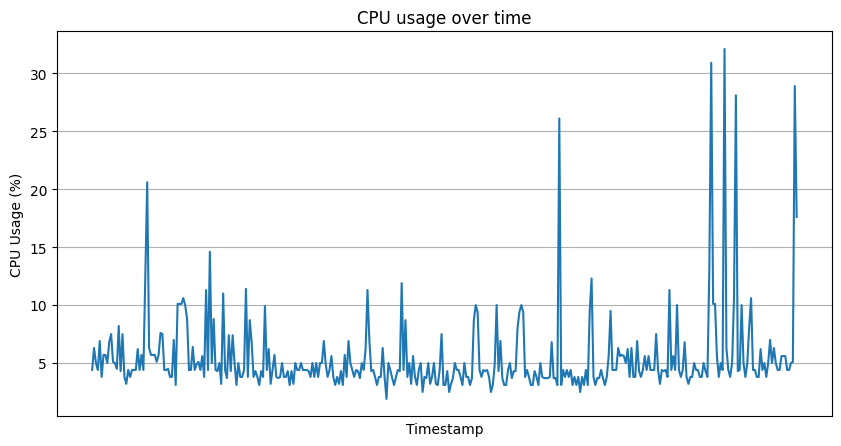

In [11]:
import matplotlib.pyplot as plt

cpu_usage_values = [hit["_source"]["cpu_usage"] for hit in hits]
timestamp_values = [hit["_source"]["@timestamp"] for hit in hits]

plt.figure(figsize=(10, 5))
plt.plot(timestamp_values, cpu_usage_values)
plt.xticks([])
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (%)")
plt.title("CPU usage over time")
plt.grid(True)
plt.show()

## Aggregations

In [12]:
response = es.search(
    index=INDEX,
    body={
        "aggs": {
            "avg_cpu_usage": {
                "avg": {
                    "field": "cpu_usage"
                }
            }
        }
    }
)

average_cpu_usage = response.body["aggregations"]["avg_cpu_usage"]["value"]
print(f"Average CPU usage: {average_cpu_usage}%")

Average CPU usage: 4.814166680199128%


In [13]:
response = es.search(
    index=INDEX,
    body={
        "aggs": {
            "max_cpu_usage": {
                "max": {
                    "field": "cpu_usage"
                }
            }
        }
    }
)

average_cpu_usage = response.body["aggregations"]["max_cpu_usage"]["value"]
print(f"Max CPU usage: {average_cpu_usage}%")

Max CPU usage: 36.5%


## Monitoring the index lifecycle

In [14]:
response = es.indices.get_data_stream()
pprint(response.body)

{'data_streams': [{'_meta': {'description': 'Template for CPU usage data'},
                   'allow_custom_routing': False,
                   'generation': 2,
                   'hidden': False,
                   'ilm_policy': 'cpu_usage_policy_v2',
                   'indices': [{'ilm_policy': 'cpu_usage_policy_v2',
                                'index_name': '.ds-cpu_example_template-2025.02.24-000001',
                                'index_uuid': 'QcfxhqPmQruejJ7RfOm6gg',
                                'managed_by': 'Index Lifecycle Management',
                                'prefer_ilm': True},
                               {'ilm_policy': 'cpu_usage_policy_v2',
                                'index_name': '.ds-cpu_example_template-2025.02.24-000002',
                                'index_uuid': 'OAB2IfKeRvu_zOs7RL4AqQ',
                                'managed_by': 'Index Lifecycle Management',
                                'prefer_ilm': True}],
                   'n

In [16]:
ilm_status = es.ilm.get_lifecycle(name="cpu_usage_policy_v2")
pprint(ilm_status.body)

{'cpu_usage_policy_v2': {'in_use_by': {'composable_templates': ['cpu_example_template'],
                                       'data_streams': ['cpu_example_template'],
                                       'indices': ['.ds-cpu_example_template-2025.02.24-000001',
                                                   '.ds-cpu_example_template-2025.02.24-000002']},
                         'modified_date': '2025-02-24T05:14:12.250Z',
                         'policy': {'phases': {'delete': {'actions': {'delete': {'delete_searchable_snapshot': True}},
                                                          'min_age': '20m'},
                                               'hot': {'actions': {'rollover': {'max_age': '5m'}},
                                                       'min_age': '0ms'}}},
                         'version': 2}}


In [17]:
response = es.ilm.explain_lifecycle(index=".ds-cpu_example_template*")
pprint(response.body)

{'indices': {'.ds-cpu_example_template-2025.02.24-000001': {'action': 'complete',
                                                            'action_time_millis': 1740375479278,
                                                            'age': '13.62m',
                                                            'index': '.ds-cpu_example_template-2025.02.24-000001',
                                                            'index_creation_date_millis': 1740375018643,
                                                            'lifecycle_date_millis': 1740375478878,
                                                            'managed': True,
                                                            'phase': 'hot',
                                                            'phase_execution': {'modified_date_in_millis': 1740374052250,
                                                                                'phase_definition': {'actions': {'rollover': {'max_age': '5m',
      